In [20]:
# adding br_demography to Python Path
import sys 
sys.path.append("../../")

import basedosdados as bd
from dotenv import load_dotenv
import os
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração
import warnings
import scipy

from br_demography import municipality_pop_pyramid as mpp

import sklearn
# Carrega as variáveis de ambiente do arquivo .env
load_dotenv(dotenv_path='../../.env')

# Use as variáveis de ambiente conforme necessário
project_id = os.getenv('GOOGLE_CLOUD_PROJECT_ID')

### Fontes de Dados sobre Domicílios Particulares Permanentes:

* Censo 1991: [Banco Multidimensional de Estatísticas](https://www.bme.ibge.gov.br/)
* Contagem da População 1996: [SIDRA - Tabela 482 - Domicílios particulares permanentes por sexo do chefe do domicílio e situação](https://sidra.ibge.gov.br/tabela/482) e <br> [Tabela 305 - População residente em domicílios particulares permanentes por sexo do chefe do domicílio e situação](https://sidra.ibge.gov.br/tabela/305)
* Censo 2000: [Tabela 2407 - Domicílios particulares permanentes e Moradores em Domicílios particulares permanentes por situação do domicílio e número de familias](https://sidra.ibge.gov.br/tabela/2407)
* Contagem 2007 [Tabela 579 - Domicílios particulares permanentes, População recenseada em domicílios particulares permanentes e Média de moradores em domicílios particulares permanentes por situação do domicílio](https://sidra.ibge.gov.br/tabela/579)
* Censo 2010: [SIDRA - Tabela 1211 - Domicílios particulares permanentes e Moradores em domicílios particulares permanentes, por espécie de unidade doméstica](https://sidra.ibge.gov.br/tabela/1211)
* Censo 2022: [SIDRA - Tabela 4711 - Domicílios recenseados, por espécie](https://sidra.ibge.gov.br/tabela/4711) e [SIDRA - Tabela 6893 - Moradores em domicílios particulares permanentes ocupados](https://sidra.ibge.gov.br/tabela/6893)



In [21]:
df = pd.read_csv('../../br_demography/source/tab/moradores_dppo.csv', sep=';', decimal=',', encoding='utf-8', index_col='cod_mun')

In [22]:
df_avg = df[['AVG MDPPO 1991', 'AVG MDPPO 1996', 'AVG MPPO 2000','AVG MDPPO 2007', 'AVG MDPPO 2010', 'AVG MDPPO 2022']]

In [23]:
df_mun = pd.read_csv('../../br_demography/source/tab/cod_mun.csv', sep=';', decimal=',', encoding='utf-8')
df_mun.rename(columns={'mun_id':'cod_mun'}, inplace=True)

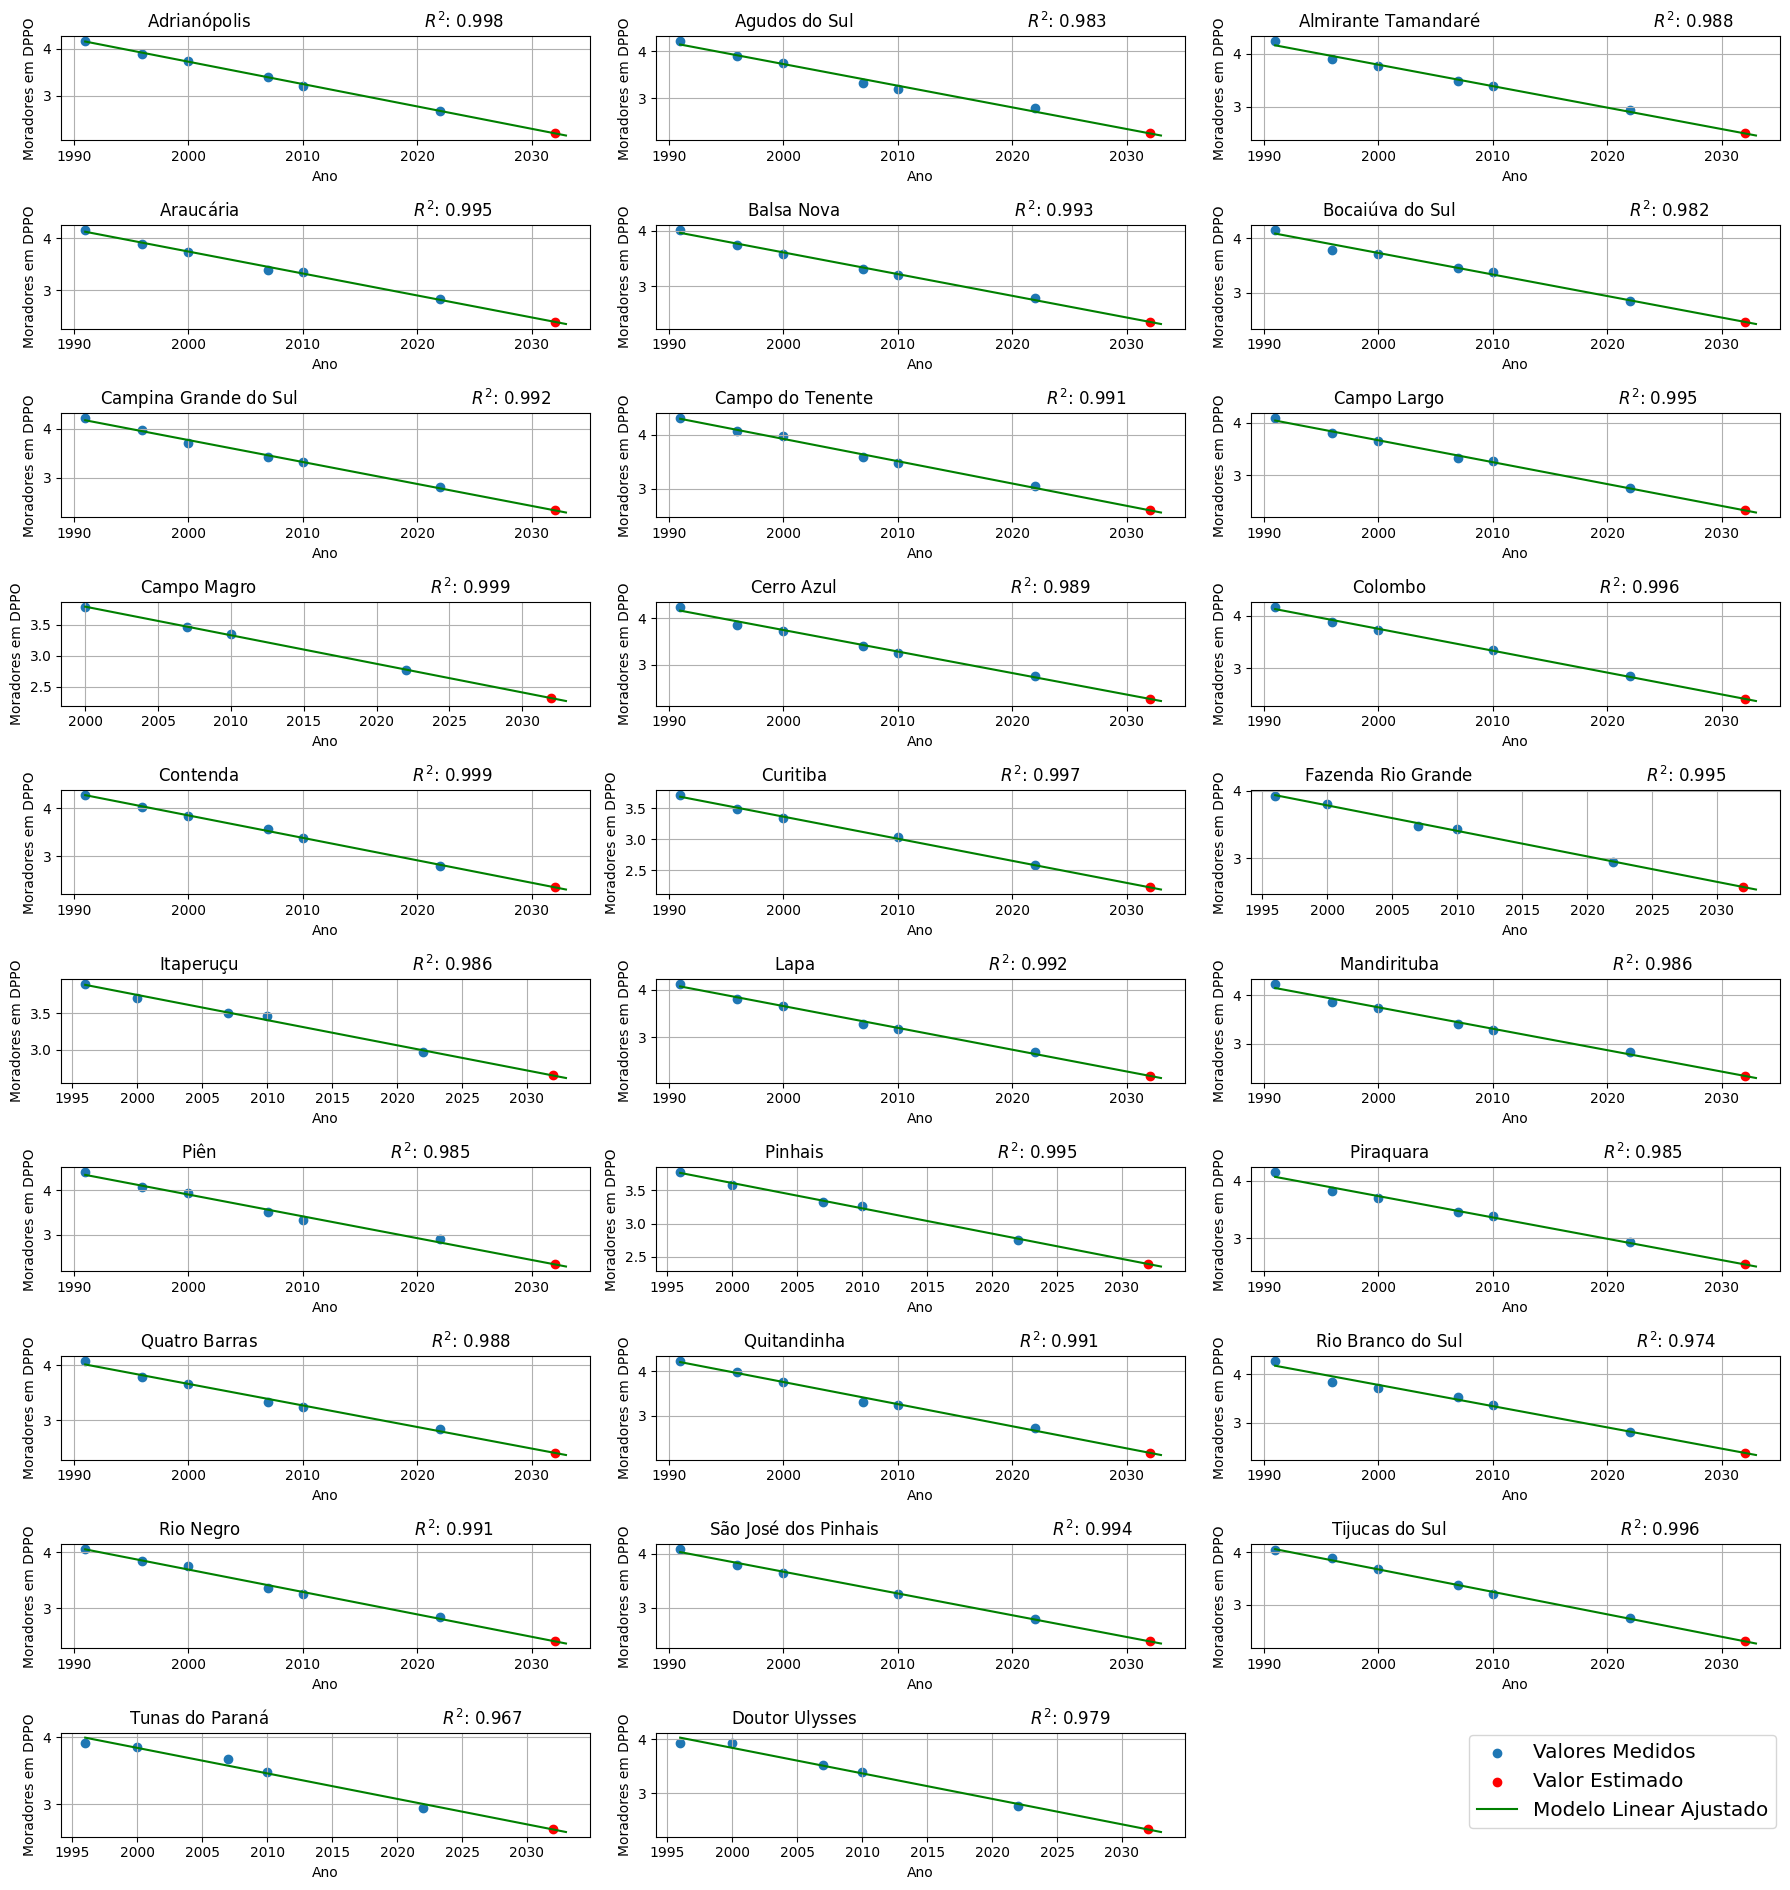

In [24]:
ncols = 3

nrows = len(df_mun) // ncols if len(df_mun) % ncols == 0 else len(df_mun) // ncols + 1 

fig, axs = plt.subplots(nrows, ncols, figsize=(18, 19))
fig.subplots_adjust(wspace=0.2, hspace=0.5)

final_year = 2032

# DataFrame de resultados
resultados = pd.DataFrame(columns=['cod_mun', 'mun', f'AVG MDPPO {final_year}'])


for i, (_, cod_mun, mun) in enumerate(df_mun.itertuples()):

    # Data
    years = df_avg.loc[cod_mun].dropna().index.str[-4:].astype(int)
    avg_household_dwellers = df_avg.loc[cod_mun].dropna().values

    # Fit a linear model
    degree_linear = 1
    coeffs_linear = np.polyfit(years, avg_household_dwellers, degree_linear)

    # Generate a polynomial function using the linear model coefficients
    poly_func_linear = np.poly1d(coeffs_linear)

    # Predict the average number of household dwellers in 2032 using the linear model
    avg_dwellers_2032_linear = poly_func_linear(final_year)

    # Calculate R-squared for the linear model
    y_pred_linear = poly_func_linear(years)
    ss_res_linear = np.sum((avg_household_dwellers - y_pred_linear) ** 2)
    ss_tot_linear = np.sum((avg_household_dwellers - np.mean(avg_household_dwellers)) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)


    x_fit_line_linear = np.linspace(years.min(), final_year+1, 100)  # Extending the line to 2030
    y_fit_line_linear = poly_func_linear(x_fit_line_linear)

    # Criar um DataFrame temporário com os resultados atuais
    df_temp = pd.DataFrame({'cod_mun':[cod_mun], 'mun':[mun], f'AVG MDPPO {final_year}':[avg_dwellers_2032_linear.round(2)]})

    # Concatenar o DataFrame temporário ao DataFrame de resultados
    resultados = pd.concat([resultados, df_temp], ignore_index=True)

    row, col = divmod(i, ncols)

    axs[row,col].scatter(years, avg_household_dwellers, label='Valores Medidos')
    axs[row,col].scatter(final_year, poly_func_linear(final_year), color='red', label='Valor Estimado')
    axs[row,col].plot(x_fit_line_linear, y_fit_line_linear, color='green', label='Modelo Linear Ajustado')
    axs[row, col].set_xlabel('Ano')
    axs[row, col].set_ylabel('Moradores em DPPO')
    axs[row, col].set_title(f'{mun}                                 $R^2$: {r_squared_linear.round(3)}')
    axs[row, col].grid(True)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.995, 0.03), fontsize='x-large', frameon=True, markerfirst=True)

last_row = (29 // ncols)
last_col = (29 % ncols) - 1  # -1 because Python indexing starts at 0

# Hide the last subplot if it's not used
if last_col + 1 < ncols:  # Checking if there are unused subplots in the last row
    for col in range(last_col + 1, ncols):
        axs[last_row, col].set_visible(False)

# Additionally, if there's a whole unused row, hide all subplots in that row
if last_row + 1 < nrows:
    for row in range(last_row + 1, nrows):
        for col in range(ncols):
            axs[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [25]:
df = pd.read_csv('../../br_demography/source/tab/moradores_dppo.csv', sep=';', decimal=',', encoding='utf-8', index_col='cod_mun')

In [26]:
resultados.set_index('mun', inplace=True)

In [27]:
df_pop = pd.read_csv('../../br_demography/results/tab/projecao_populacional_rmc_2022_2042_2.csv', sep=';', decimal=',', encoding='utf-16')

In [28]:
df_pop.rename(columns={'Município':'mun'}, inplace=True)

In [29]:
resultados = resultados.join(df_pop.groupby(by=['mun'])[['População 2032']].sum())

In [30]:
resultados['DPPO 2032'] = (resultados['População 2032'] / resultados['AVG MDPPO 2032']).astype(int)

In [31]:
resultados = resultados.reset_index().set_index('cod_mun').join(df.drop(columns=['mun']))

In [32]:
resultados.to_csv(path_or_buf='../../br_demography/results/tab/projecao_domicilios_2032.csv', sep=';', decimal=',', encoding='utf-16')

In [33]:
df_dppo = resultados[['DPPO 1991','DPPO 1996', 'DPPO 2000', 'DPPO 2007', 'DPPO 2010', 'DPPO 2022', 'DPPO 2032']]

In [34]:
df_dppo.columns = df_dppo.columns.str.slice(5)

In [35]:
df_land_use = pd.read_csv('../../br_demography/source/tab/biomes_land_use.csv', sep=';', decimal=',')

In [36]:
df_dppo.loc[cod_mun].to_frame().rename(columns={4100202:'DPPO'})

,4128633
1991,NaN
1996,1438.0
2000,1498.0
2007,1683.0
2010,1685.0
2022,2067.0
2032,2520.0


In [42]:
df_train = (
    df_land_use
    .rename(columns={'geocode':'cod_mun'})
    .loc[
        (df_land_use['geocode'].isin(df_mun['cod_mun'])) & 
        (df_land_use['level_2'] == 'Urban Infrastructure')
        ]
    .set_index('cod_mun')
    .loc[:,df_dppo.columns[:-1]]
    .loc[cod_mun]
    .to_frame()
    .rename(columns={cod_mun:'UrbArea'})
    .join(df_dppo.loc[cod_mun].to_frame().rename(columns={cod_mun:'DPPO'}))
    .dropna()
    )

In [82]:
(
        df_land_use
        .rename(columns={'geocode':'cod_mun'})
        .loc[
            (df_land_use['geocode'].isin(df_mun['cod_mun'])) & 
            (df_land_use['level_2'] == 'Urban Infrastructure')
            ]
        .set_index('cod_mun')
        .loc[:,df_dppo.columns[2:-1]]
        .loc[cod_mun]
        .to_frame()
        .rename(columns={cod_mun:'UrbArea'})
        .join(df_dppo.loc[cod_mun].to_frame().rename(columns={cod_mun:'DPPO'}))
        .dropna()
        )

,UrbArea,DPPO
2000,9.127104,1498.0
2007,17.439425,1683.0
2010,26.485213,1685.0
2022,35.775552,2067.0


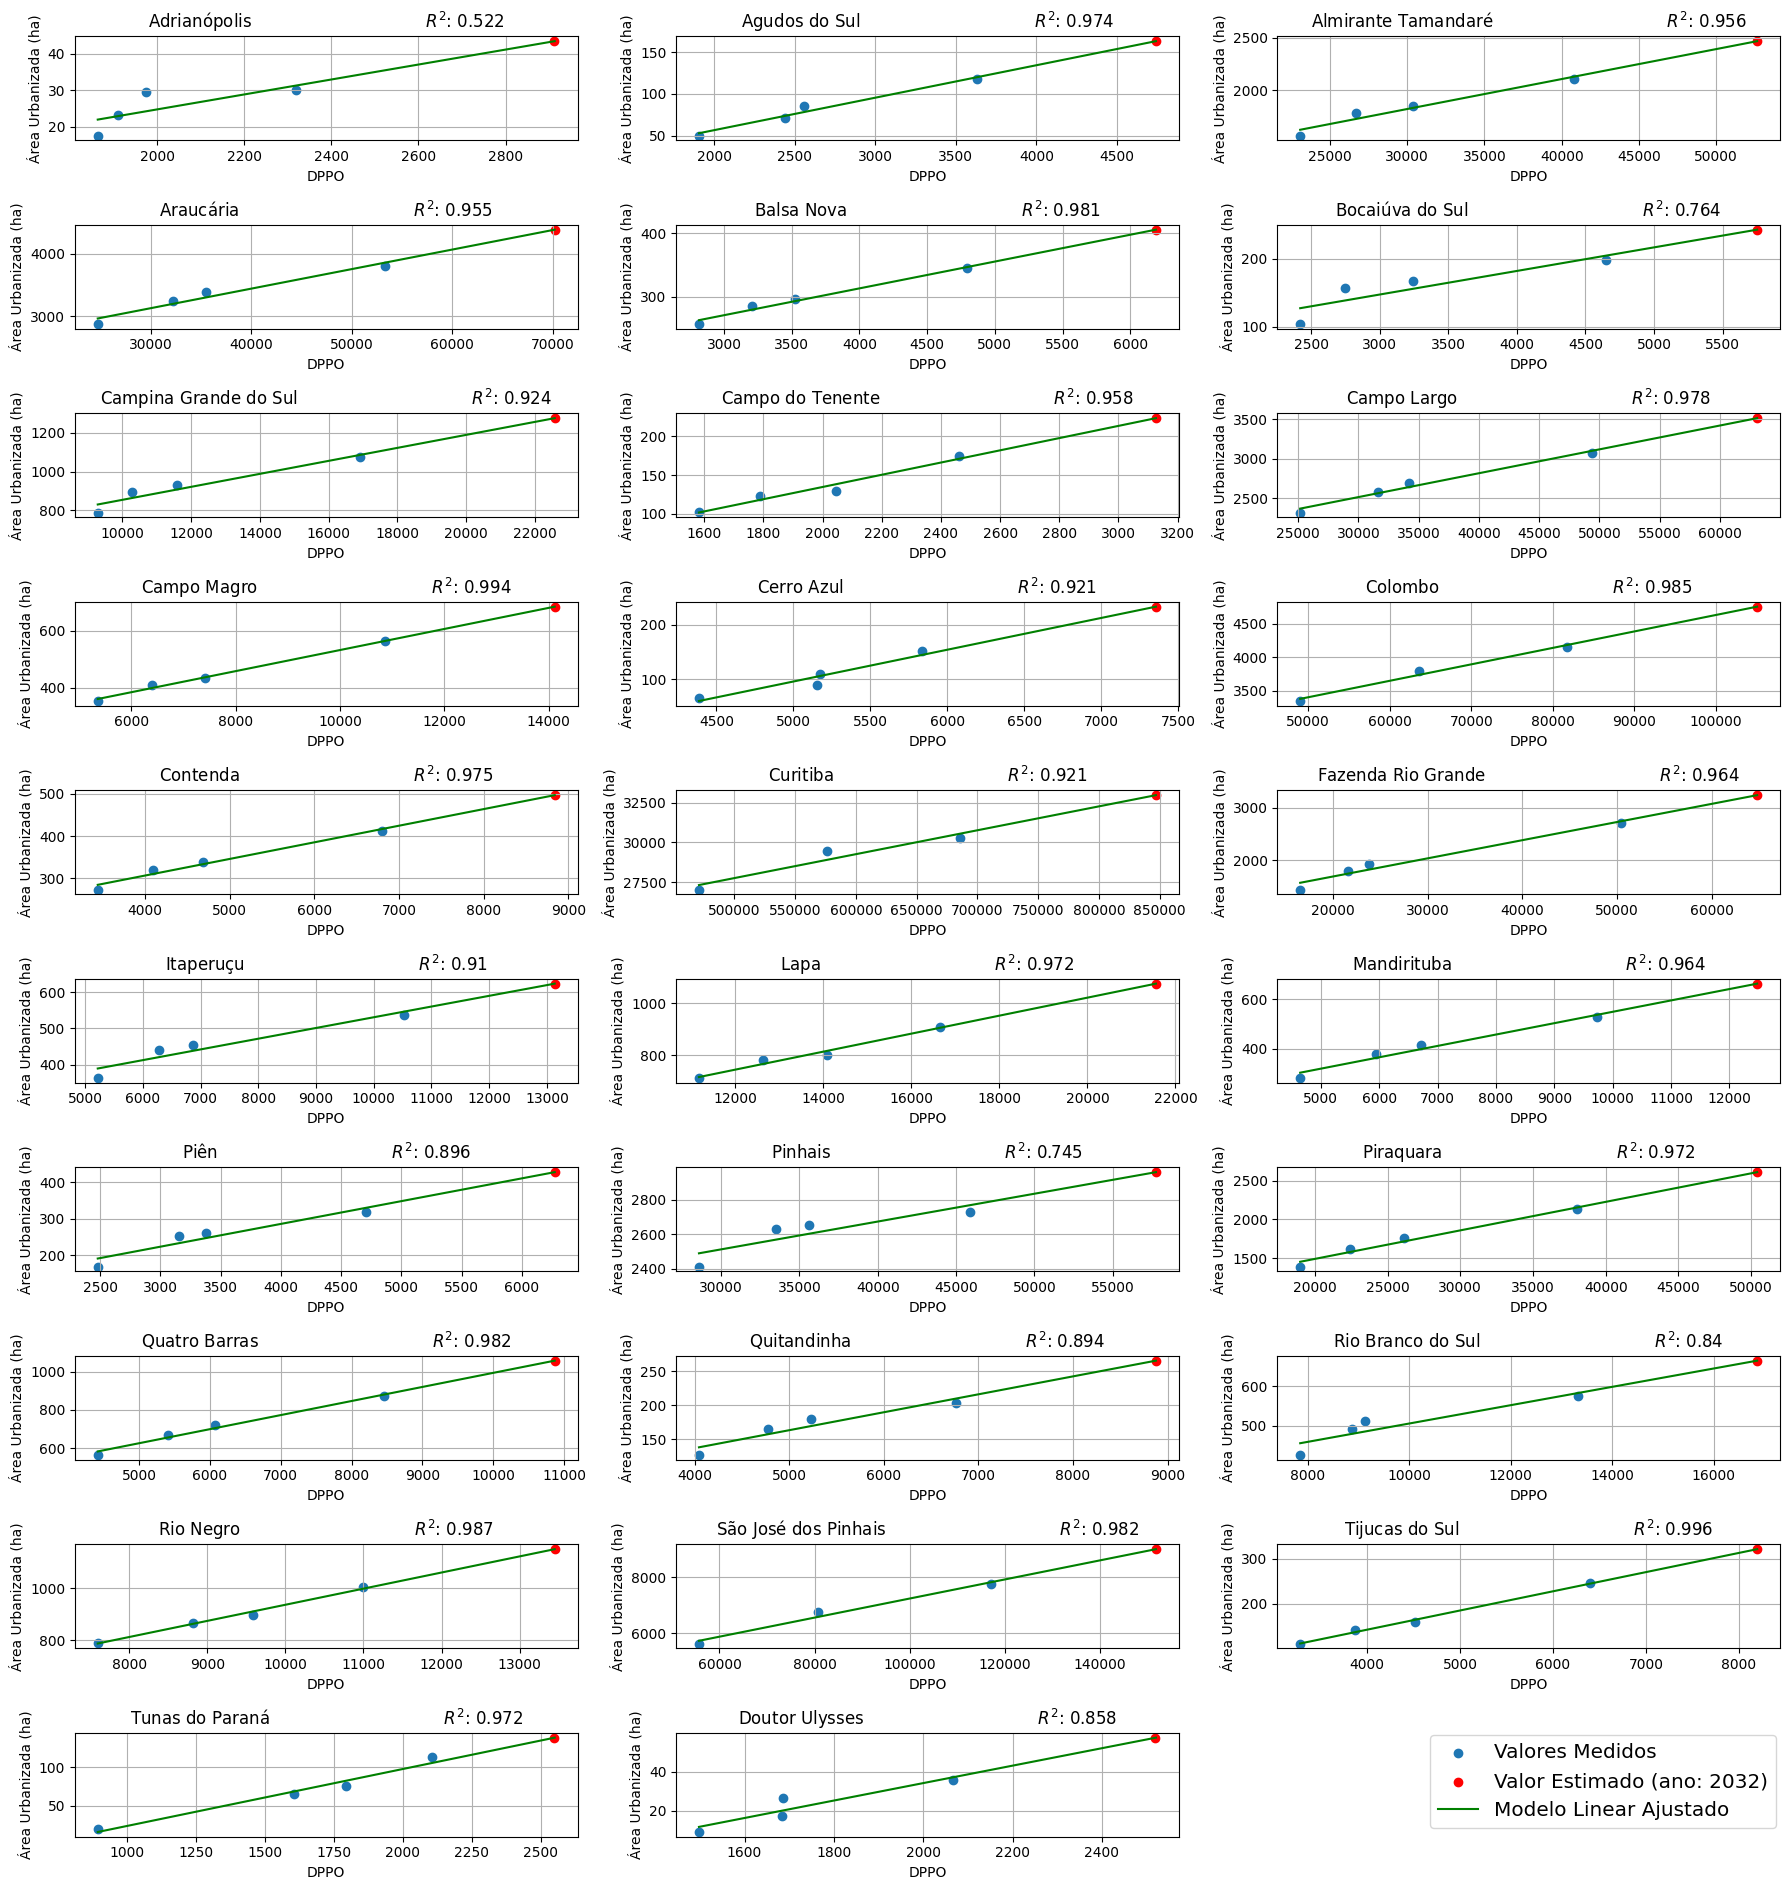

In [85]:
ncols = 3

nrows = len(df_mun) // ncols if len(df_mun) % ncols == 0 else len(df_mun) // ncols + 1 

fig, axs = plt.subplots(nrows, ncols, figsize=(18, 19))
fig.subplots_adjust(wspace=0.2, hspace=0.5)

# DataFrame de resultados
resultados = pd.DataFrame(columns=['cod_mun', 'mun', f'Área Urbana {df_dppo.columns.astype(int).max()} (ha)'])


for i, (_, cod_mun, mun) in enumerate(df_mun.itertuples()):

    # Data

    """
    urban_area = (
        df_land_use
        .rename(columns={'geocode':'cod_mun'})
        .loc[
            (df_land_use['geocode'].isin(df_mun['cod_mun'])) & 
            (df_land_use['level_2'] == 'Urban Infrastructure')
            ]
        .set_index('cod_mun')
        .loc[:,df_dppo.columns[:-1]]
        .loc[cod_mun]
        .dropna()
        )
    """    
    df_train = (
        df_land_use
        .rename(columns={'geocode':'cod_mun'})
        .loc[
            (df_land_use['geocode'].isin(df_mun['cod_mun'])) & 
            (df_land_use['level_2'] == 'Urban Infrastructure')
            ]
        .set_index('cod_mun')
        .loc[:,df_dppo.columns[2:-1]]
        .loc[cod_mun]
        .to_frame()
        .rename(columns={cod_mun:'UrbArea'})
        .join(df_dppo.loc[cod_mun].to_frame().rename(columns={cod_mun:'DPPO'}))
        .dropna()
        )
    
    urban_area = df_train['UrbArea']

    dppo = df_train['DPPO']


    # Fit a linear model
    degree_linear = 1
    coeffs_linear = np.polyfit(dppo, urban_area, degree_linear)

    # Generate a polynomial function using the linear model coefficients
    poly_func_linear = np.poly1d(coeffs_linear)

    dppo_future = df_dppo['2032'].loc[cod_mun]

    # Predict the average number of household dwellers in 2032 using the linear model
    urban_area_future = poly_func_linear(dppo_future)

    # Calculate R-squared for the linear model
    y_pred_linear = poly_func_linear(dppo)
    ss_res_linear = np.sum((urban_area - y_pred_linear) ** 2)
    ss_tot_linear = np.sum((urban_area - np.mean(urban_area)) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)


    x_fit_line_linear = np.linspace(dppo.min(), dppo_future+1, 100)
    y_fit_line_linear = poly_func_linear(x_fit_line_linear)

    # Criar um DataFrame temporário com os resultados atuais
    df_temp = pd.DataFrame({'cod_mun':[cod_mun], 'mun':[mun], f'Área Urbana {df_dppo.columns.astype(int).max()} (ha)':[urban_area_future.round(2)]})

    # Concatenar o DataFrame temporário ao DataFrame de resultados
    resultados = pd.concat([resultados, df_temp], ignore_index=True)

    row, col = divmod(i, ncols)

    axs[row,col].scatter(dppo, urban_area, label='Valores Medidos')
    axs[row,col].scatter(dppo_future, poly_func_linear(dppo_future), color='red', label=f'Valor Estimado (ano: {df_dppo.columns.astype(int).max()})')
    axs[row,col].plot(x_fit_line_linear, y_fit_line_linear, color='green', label='Modelo Linear Ajustado')
    axs[row, col].set_xlabel('DPPO')
    axs[row, col].set_ylabel('Área Urbanizada (ha)')
    axs[row, col].set_title(f'{mun}                                 $R^2$: {r_squared_linear.round(3)}')
    axs[row, col].grid(True)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.995, 0.03), fontsize='x-large', frameon=True, markerfirst=True)

last_row = (29 // ncols)
last_col = (29 % ncols) - 1  # -1 because Python indexing starts at 0

# Hide the last subplot if it's not used
if last_col + 1 < ncols:  # Checking if there are unused subplots in the last row
    for col in range(last_col + 1, ncols):
        axs[last_row, col].set_visible(False)

# Additionally, if there's a whole unused row, hide all subplots in that row
if last_row + 1 < nrows:
    for row in range(last_row + 1, nrows):
        for col in range(ncols):
            axs[row, col].set_visible(False)

plt.tight_layout()
plt.savefig('../../br_demography/results/fig/urban areas/regression_urban_areas_x_dppo_2000_2032.png')
plt.show()

In [60]:
df_dppo.to_clipboard()

In [78]:
(
    df_land_use
    .rename(columns={'geocode':'cod_mun'})
    .loc[
        (df_land_use['geocode'].isin(df_mun['cod_mun'])) & 
        (df_land_use['level_2'] == 'Urban Infrastructure')
        ]
    .set_index(['cod_mun', 'municipality'])
    .loc[:,df_dppo.columns[:-1]]
    .loc[df_mun['cod_mun'].values]
).to_clipboard()

In [84]:
resultados.to_clipboard()

4100202 Adrianópolis


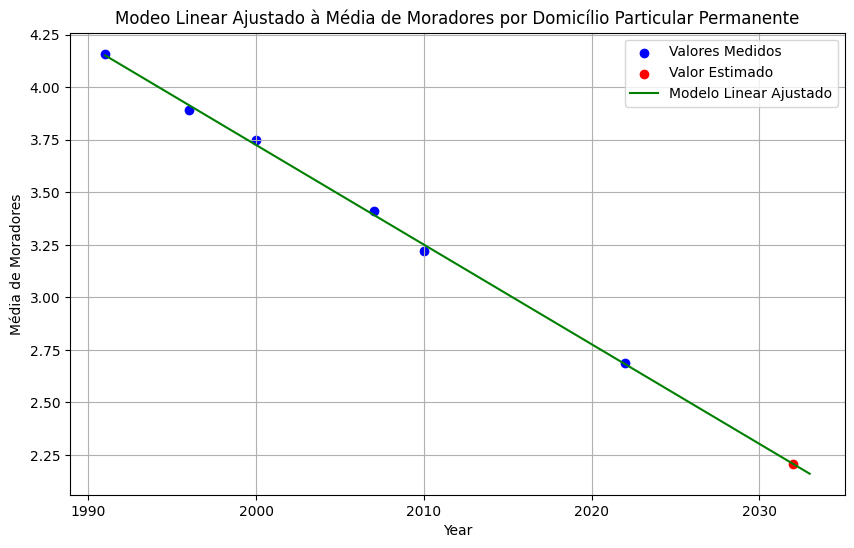

4100301 Agudos do Sul


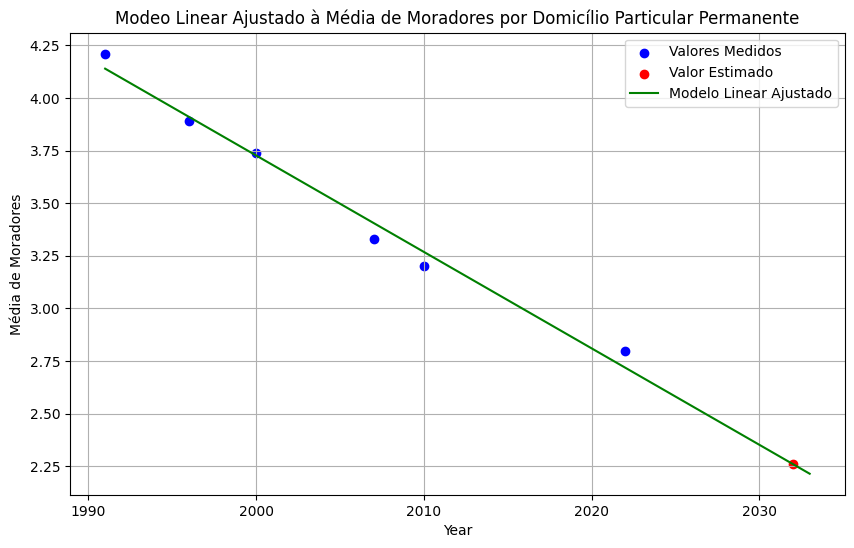

4100400 Almirante Tamandaré


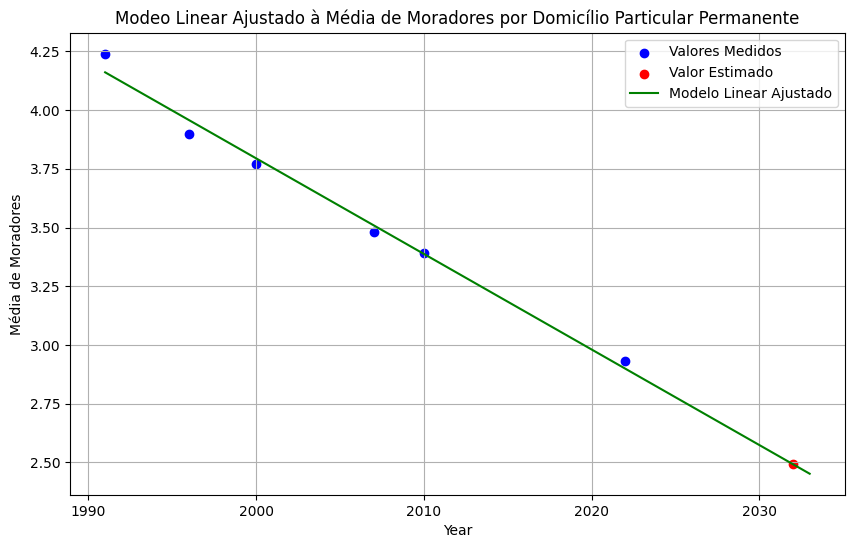

4101804 Araucária


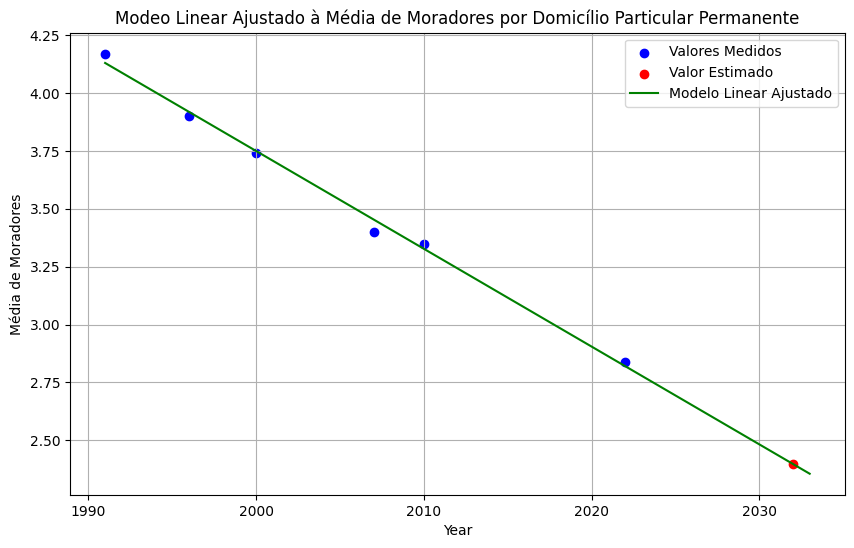

4102307 Balsa Nova


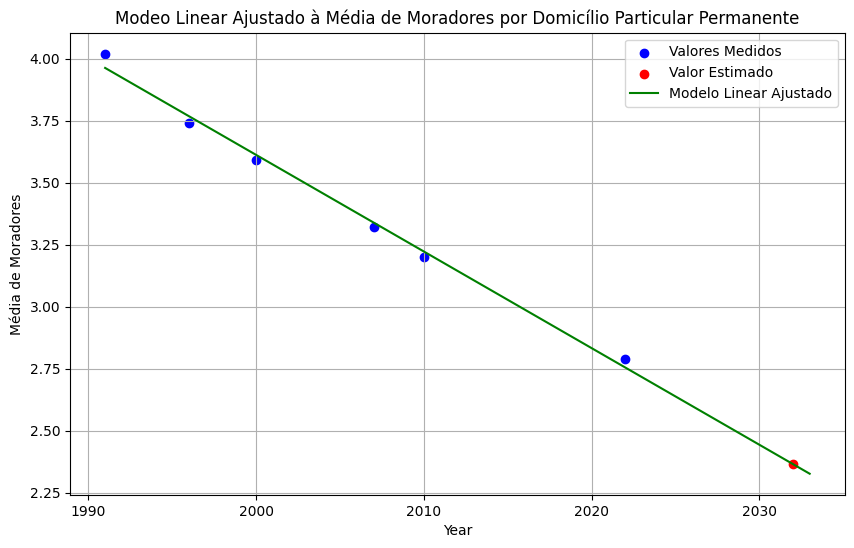

4103107 Bocaiúva do Sul


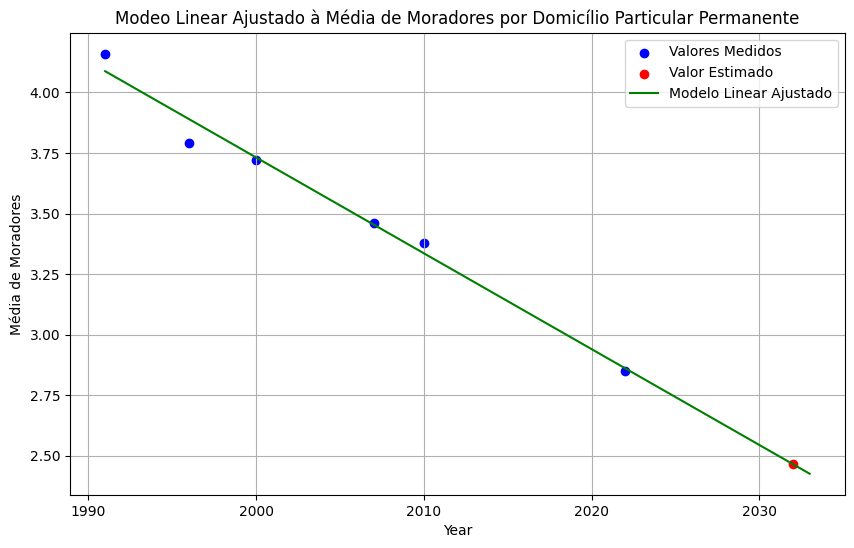

4104006 Campina Grande do Sul


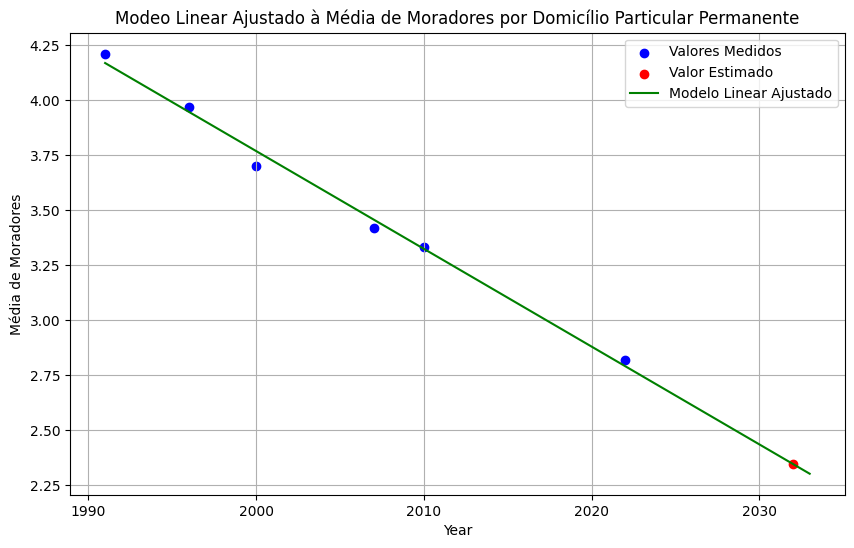

4104105 Campo do Tenente


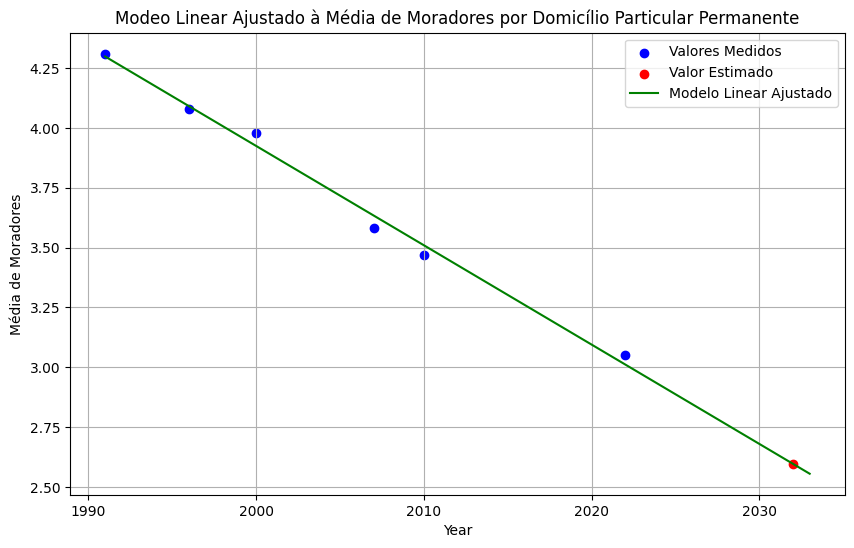

4104204 Campo Largo


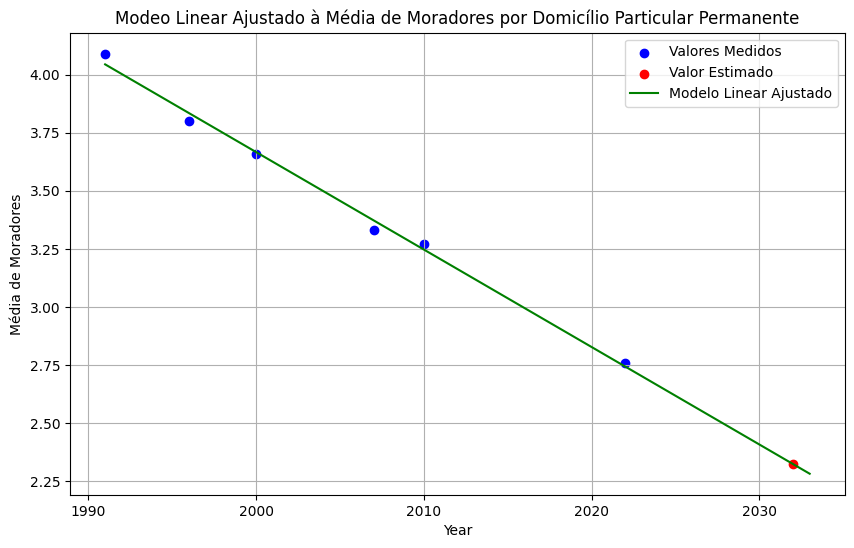

4104253 Campo Magro


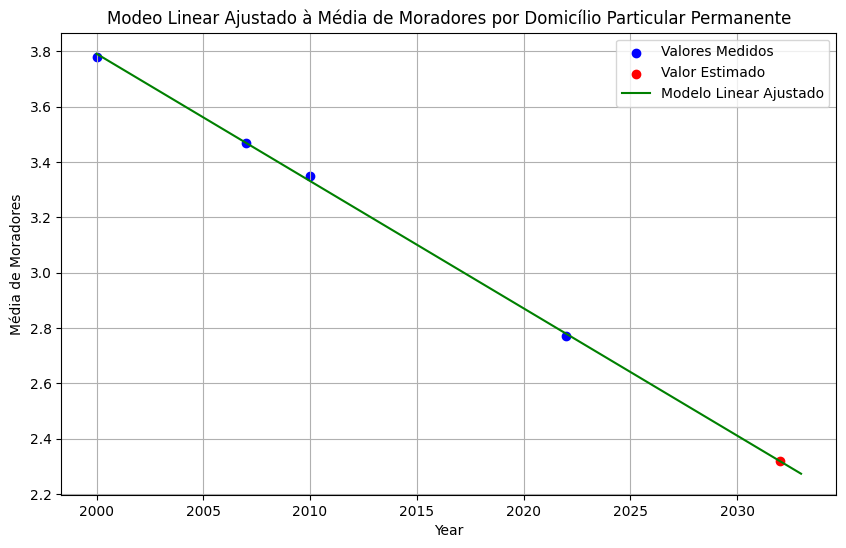

4105201 Cerro Azul


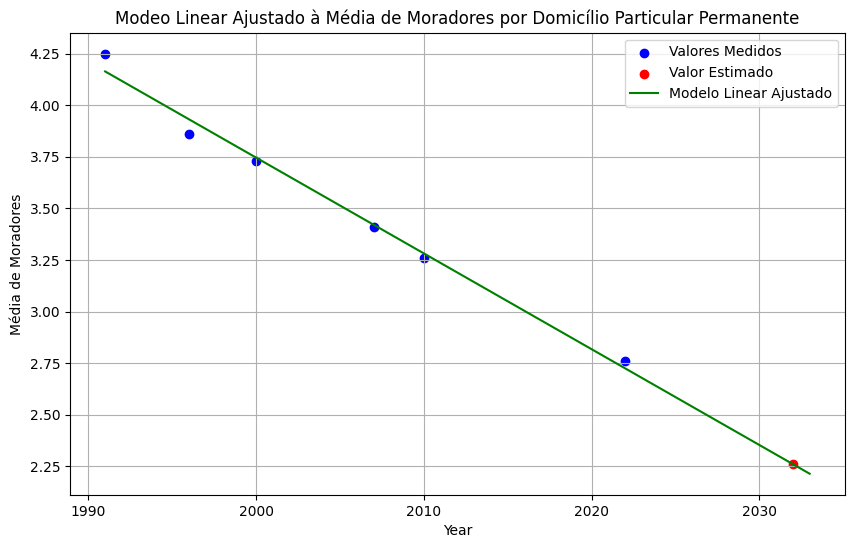

4105805 Colombo


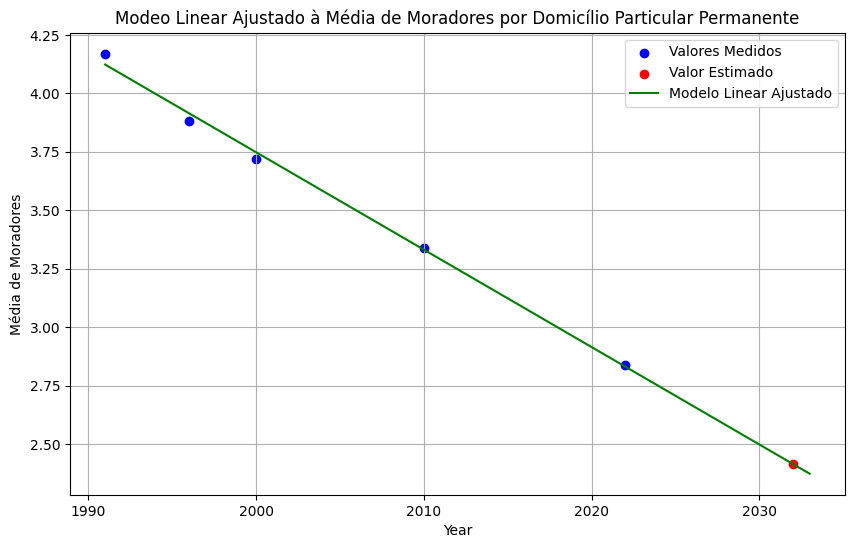

4106209 Contenda


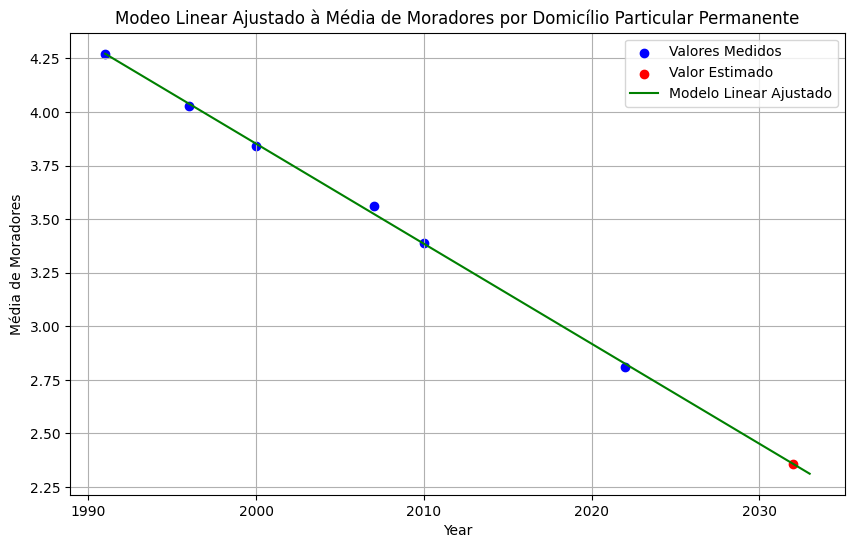

4106902 Curitiba


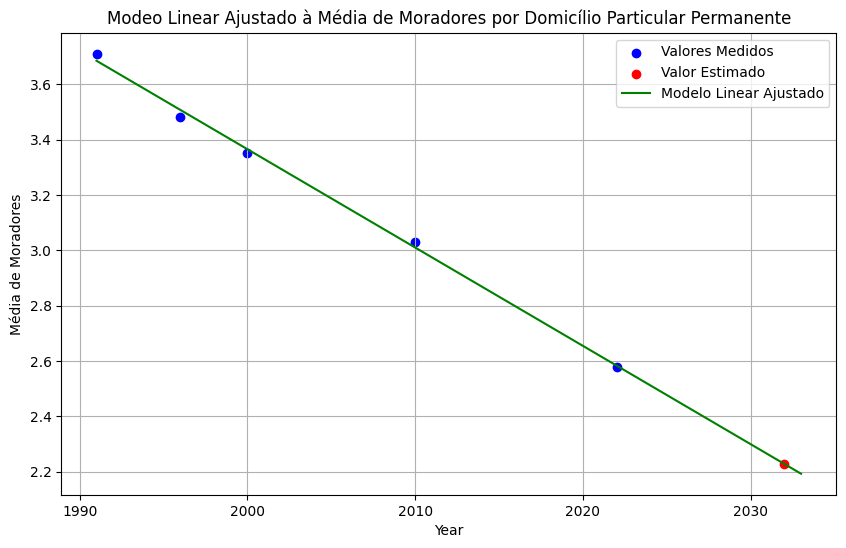

4107652 Fazenda Rio Grande


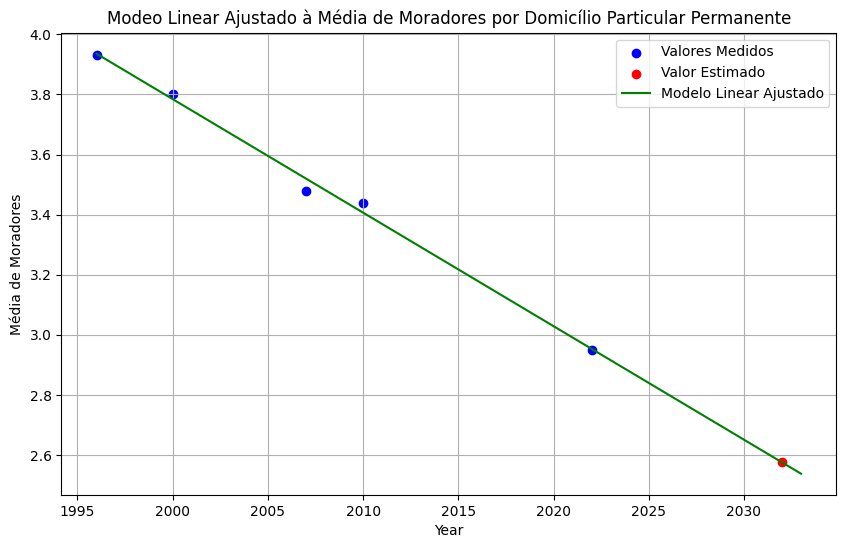

4111258 Itaperuçu


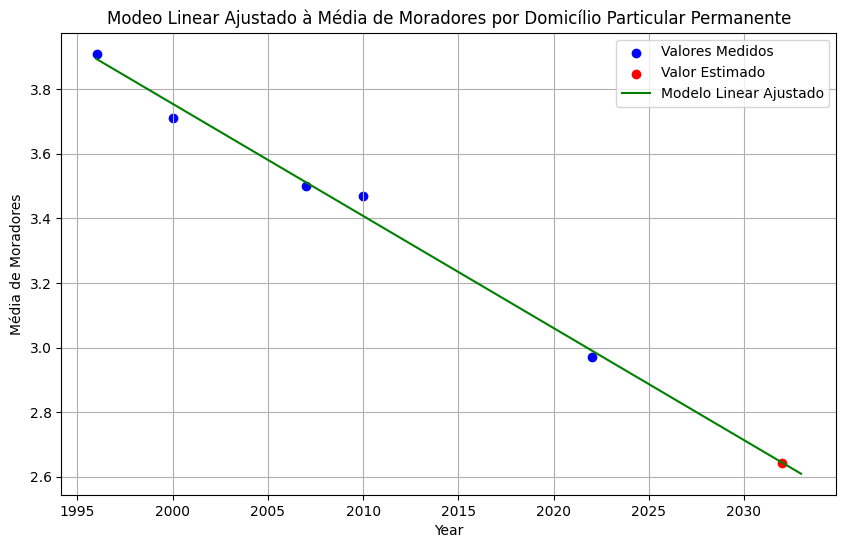

4113205 Lapa


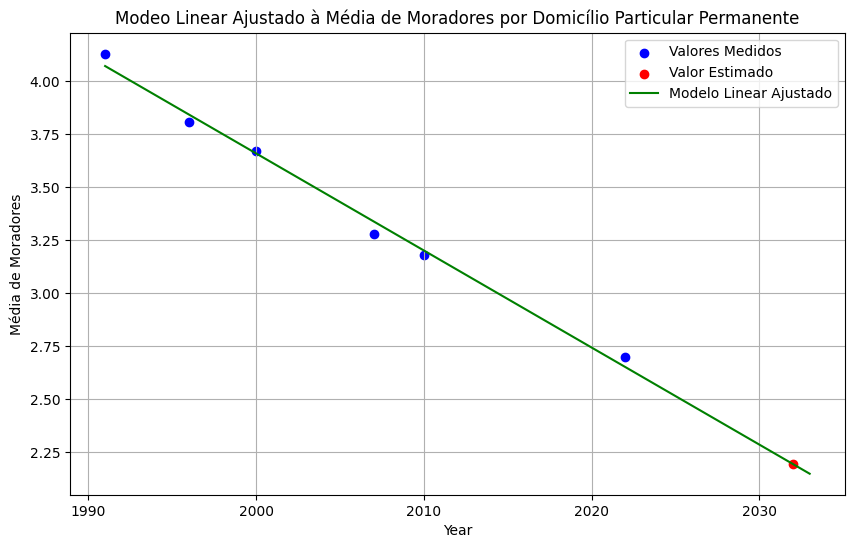

4114302 Mandirituba


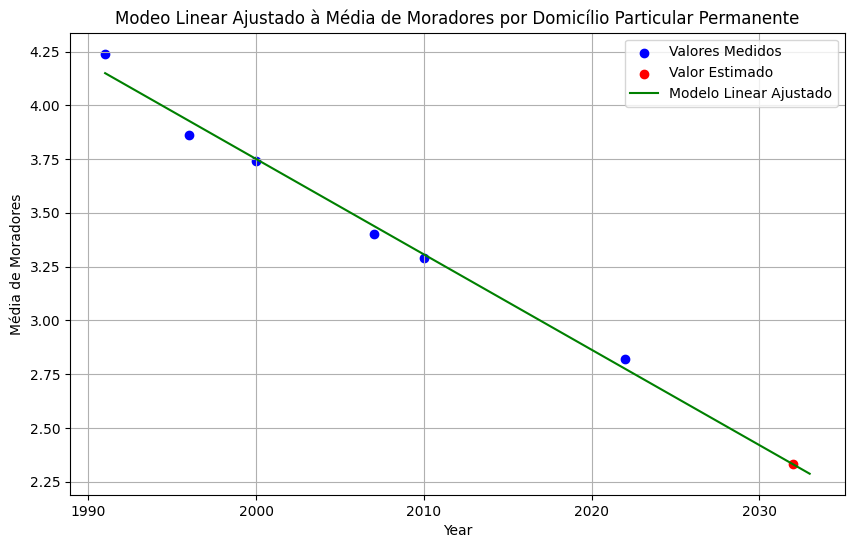

4119103 Piên


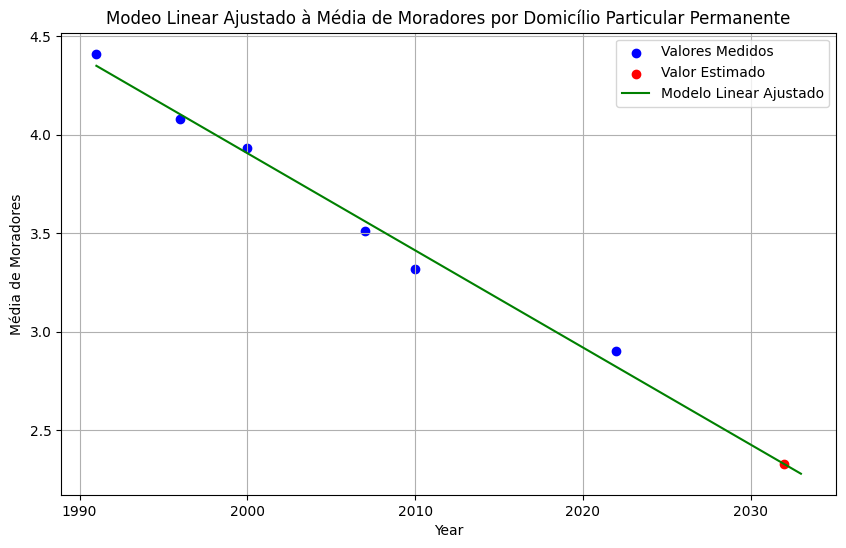

4119152 Pinhais


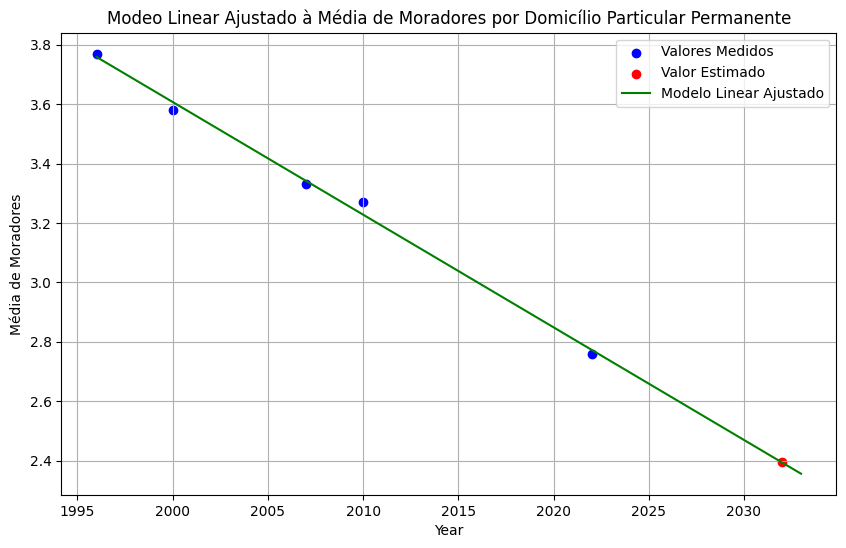

4119509 Piraquara


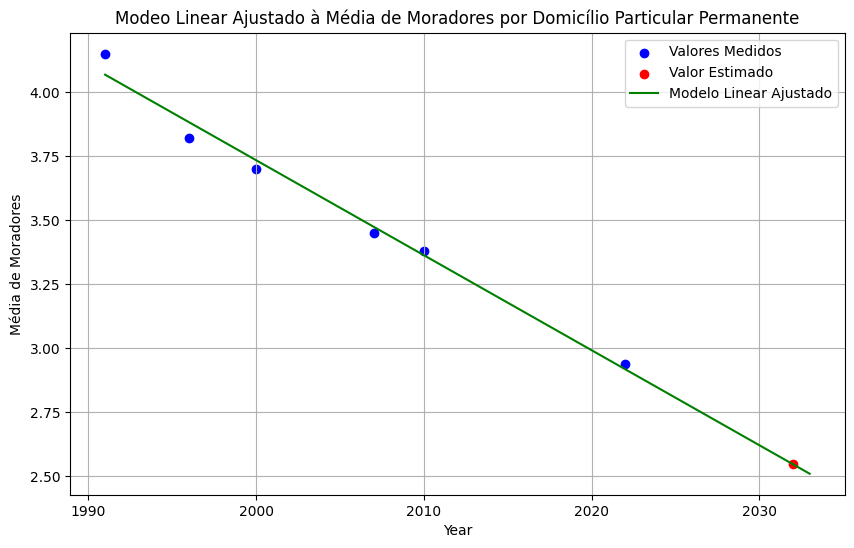

4120804 Quatro Barras


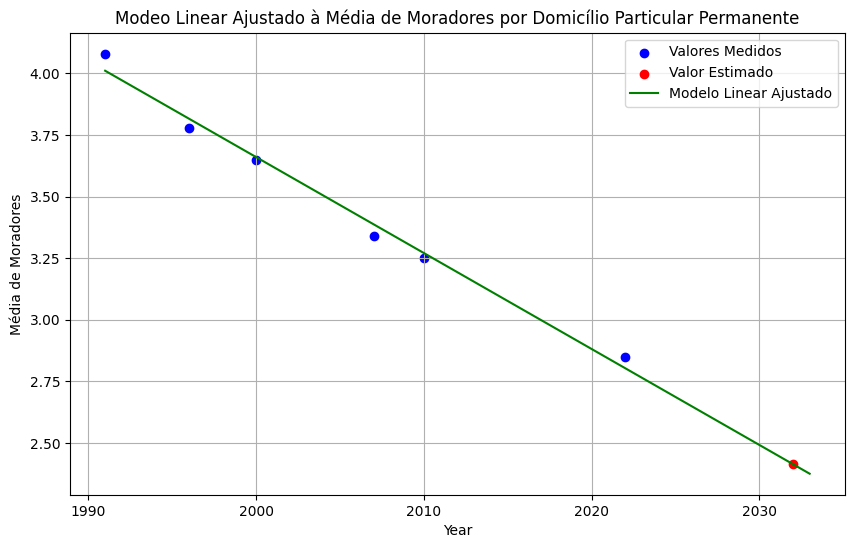

4121208 Quitandinha


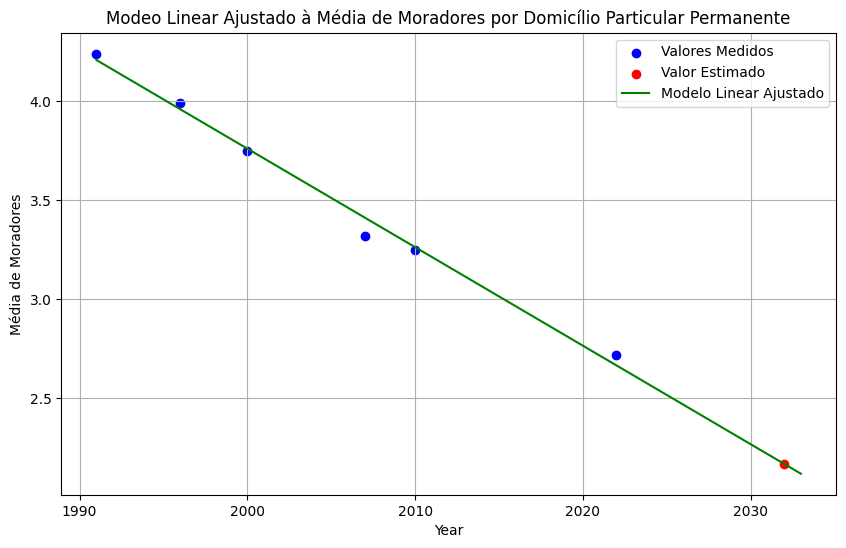

4122206 Rio Branco do Sul


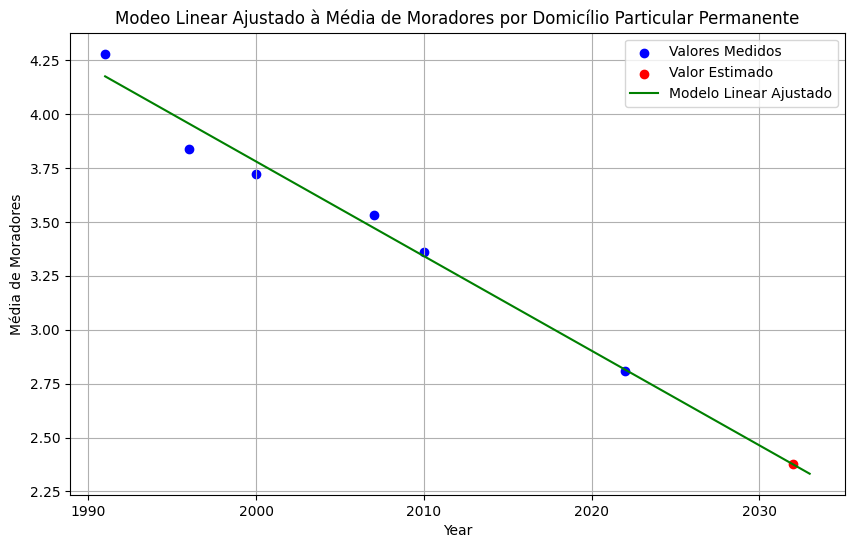

4122305 Rio Negro


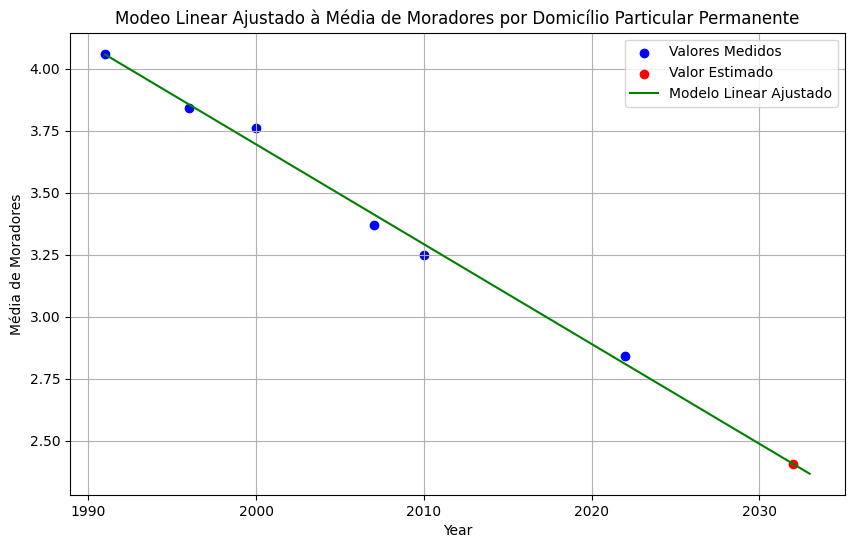

4125506 São José dos Pinhais


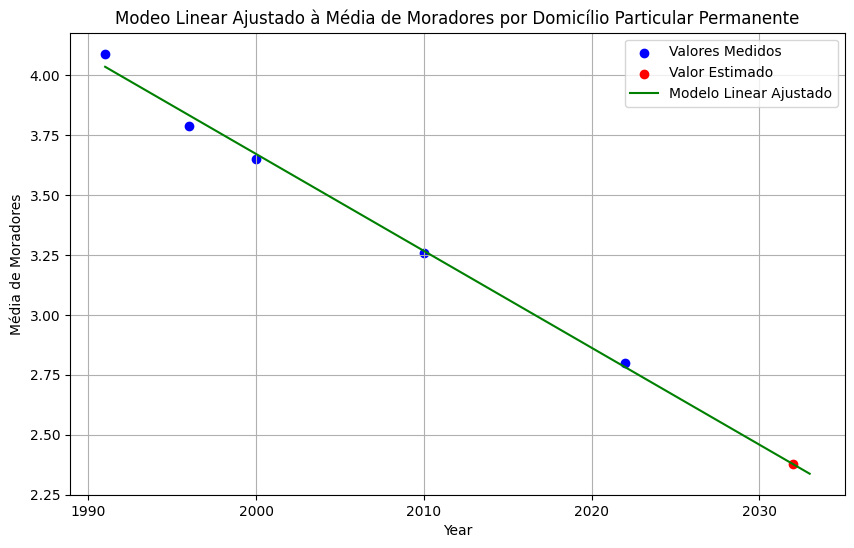

4127601 Tijucas do Sul


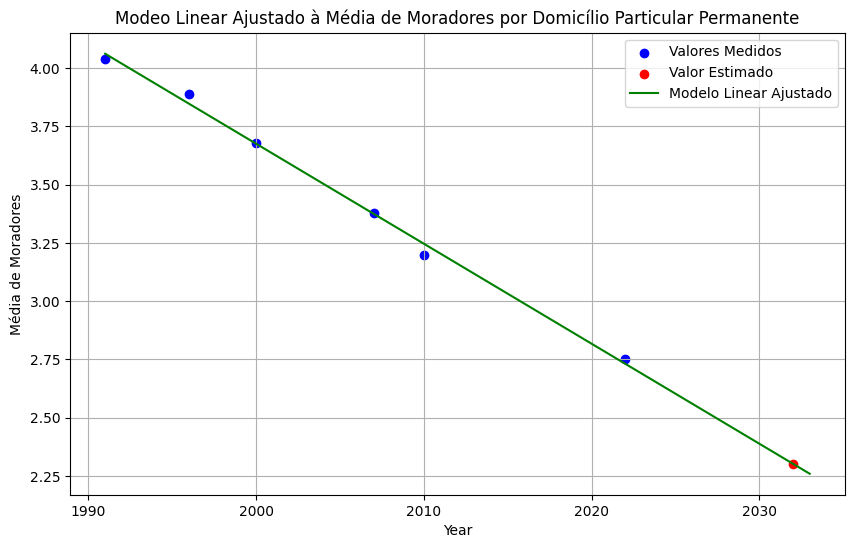

4127882 Tunas do Paraná


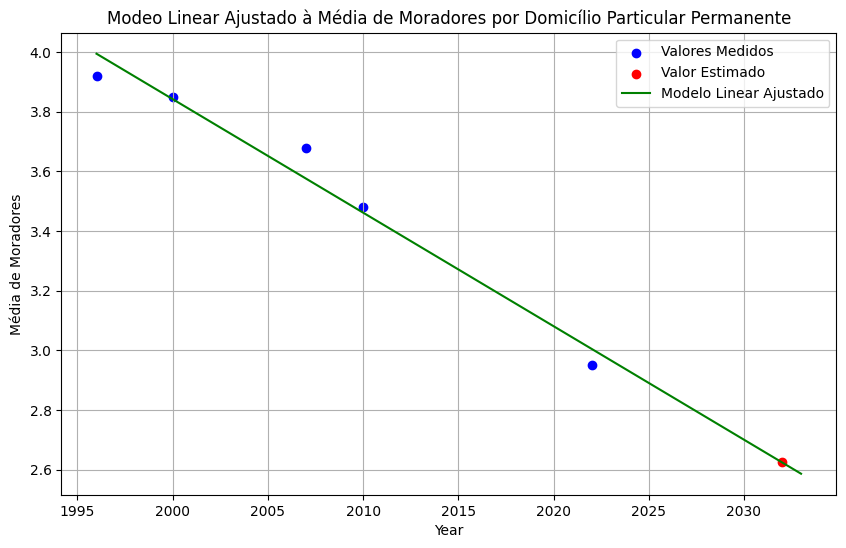

4128633 Doutor Ulysses


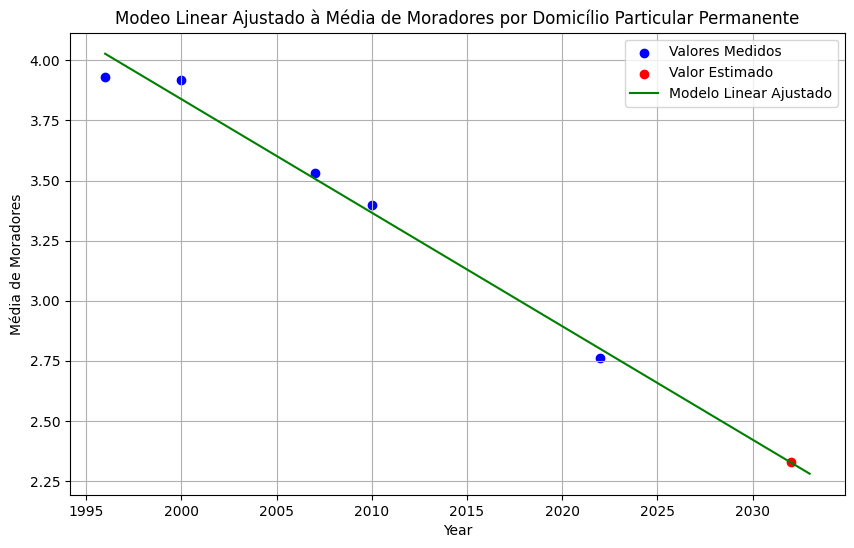

In [44]:
ncols = 3

nrows = len(df_mun) // num_cols if len(df_mun) % num_cols == 0 else len(df_mun) // num_cols + 1 

fig = plt.subplot(nrows,ncols)
fig.

for i, (_, cod_mun, mun) in enumerate(df_mun.itertuples()):
    print(cod_mun, mun)

    # Data
    years = df_avg.loc[cod_mun].dropna().index.str[-4:].astype(int)
    avg_household_dwellers = df_avg.loc[cod_mun].dropna().values

    year_2032 = 2032

    # Fit a linear model
    degree_linear = 1
    coeffs_linear = np.polyfit(years, avg_household_dwellers, degree_linear)

    # Generate a polynomial function using the linear model coefficients
    poly_func_linear = np.poly1d(coeffs_linear)

    # Predict the average number of household dwellers in 2032 using the linear model
    avg_dwellers_2032_linear = poly_func_linear(year_2032)

    # Calculate R-squared for the linear model
    y_pred_linear = poly_func_linear(years)
    ss_res_linear = np.sum((avg_household_dwellers - y_pred_linear) ** 2)
    ss_tot_linear = np.sum((avg_household_dwellers - np.mean(avg_household_dwellers)) ** 2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)

    # Plotting for the linear model
    plt.figure(figsize=(10, 6))
    # Scatter plot of the input data
    plt.scatter(years, avg_household_dwellers, color='blue', label='Valores Medidos')
    plt.scatter(2032, poly_func_linear(2032), color='red', label='Valor Estimado')

    # Fit line for linear model
    x_fit_line_linear = np.linspace(years.min(), 2033, 100)  # Extending the line to 2030
    y_fit_line_linear = poly_func_linear(x_fit_line_linear)
    plt.plot(x_fit_line_linear, y_fit_line_linear, color='green', label='Modelo Linear Ajustado')

    # Styling the plot
    plt.title('Modeo Linear Ajustado à Média de Moradores por Domicílio Particular Permanente')
    plt.xlabel('Year')
    plt.ylabel('Média de Moradores')
    plt.legend()
    plt.grid(True)

    plt.show()

    (avg_dwellers_2032_linear, r_squared_linear, coeffs_linear)


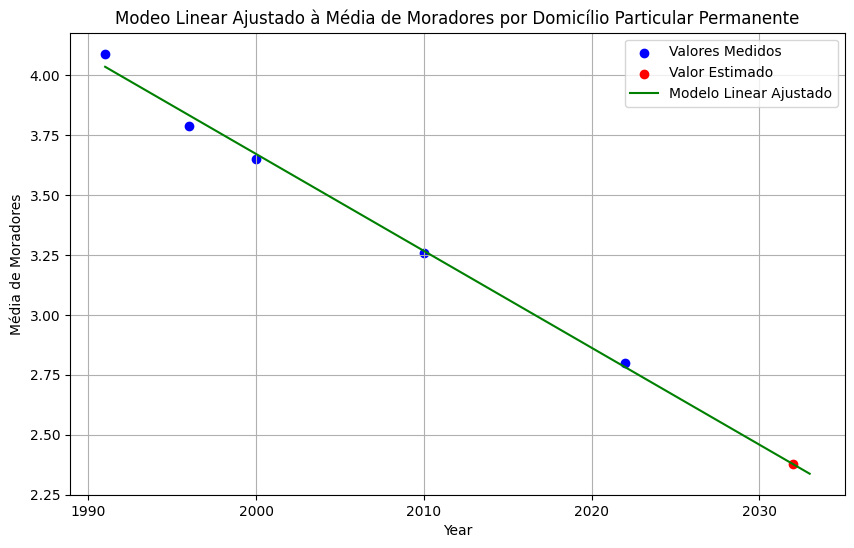

(2.377956636005223,
 0.9943149039730511,
 array([-4.04270696e-02,  8.45257622e+01]))

In [34]:
# Data
years = df_avg.loc[4125506].dropna().index.str[-4:].astype(int)
avg_household_dwellers = df_avg.loc[4125506].dropna().values

year_2032 = 2032

# Fit a linear model
degree_linear = 1
coeffs_linear = np.polyfit(years, avg_household_dwellers, degree_linear)

# Generate a polynomial function using the linear model coefficients
poly_func_linear = np.poly1d(coeffs_linear)

# Predict the average number of household dwellers in 2032 using the linear model
avg_dwellers_2032_linear = poly_func_linear(year_2032)

# Calculate R-squared for the linear model
y_pred_linear = poly_func_linear(years)
ss_res_linear = np.sum((avg_household_dwellers - y_pred_linear) ** 2)
ss_tot_linear = np.sum((avg_household_dwellers - np.mean(avg_household_dwellers)) ** 2)
r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)

# Plotting for the linear model
plt.figure(figsize=(10, 6))
# Scatter plot of the input data
plt.scatter(years, avg_household_dwellers, color='blue', label='Valores Medidos')
plt.scatter(2032, poly_func_linear(2032), color='red', label='Valor Estimado')

# Fit line for linear model
x_fit_line_linear = np.linspace(years.min(), 2033, 100)  # Extending the line to 2030
y_fit_line_linear = poly_func_linear(x_fit_line_linear)
plt.plot(x_fit_line_linear, y_fit_line_linear, color='green', label='Modelo Linear Ajustado')

# Styling the plot
plt.title('Modeo Linear Ajustado à Média de Moradores por Domicílio Particular Permanente')
plt.xlabel('Year')
plt.ylabel('Média de Moradores')
plt.legend()
plt.grid(True)

plt.show()

(avg_dwellers_2032_linear, r_squared_linear, coeffs_linear)


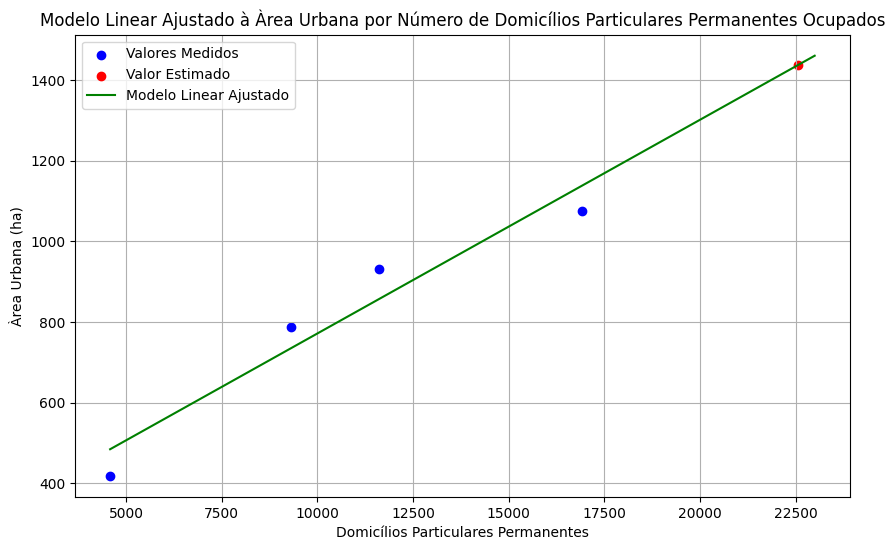

(1438.3350172111295,
 0.9293517583828461,
 array([5.30040514e-02, 2.41662549e+02]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
area_urbana = np.array([418.70, 788.66, 931.39, 1075.59])
domicilios = np.array([4580, 9301, 11598, 16927])
1
# Fit a linear model
degree_linear = 1
coeffs_linear = np.polyfit(domicilios, area_urbana, degree_linear)

# Generate a polynomial function using the linear model coefficients
poly_func_linear = np.poly1d(coeffs_linear)

domicilios_2032 =  22577

# Predict the average number of household dwellers in 2032 using the linear model
domicilios_2032_linear = poly_func_linear(domicilios_2032)

# Calculate R-squared for the linear model
y_pred_linear = poly_func_linear(domicilios)
ss_res_linear = np.sum((area_urbana - y_pred_linear) ** 2)
ss_tot_linear = np.sum((area_urbana - np.mean(area_urbana)) ** 2)
r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)

# Plotting for the linear model
plt.figure(figsize=(10, 6))
# Scatter plot of the input data
plt.scatter(domicilios, area_urbana, color='blue', label='Valores Medidos')
plt.scatter(domicilios_2032, poly_func_linear(domicilios_2032), color='red', label='Valor Estimado')

# Fit line for linear model
x_fit_line_linear = np.linspace(domicilios.min(), round(domicilios_2032, -3), 100)  # Extending the line to 2030
y_fit_line_linear = poly_func_linear(x_fit_line_linear)
plt.plot(x_fit_line_linear, y_fit_line_linear, color='green', label='Modelo Linear Ajustado')

# Styling the plot
plt.title('Modelo Linear Ajustado à Àrea Urbana por Número de Domicílios Particulares Permanentes Ocupados')
plt.xlabel('Domicílios Particulares Permanentes')
plt.ylabel('Àrea Urbana (ha)')
plt.legend()
plt.grid(True)

plt.show()

(domicilios_2032_linear, r_squared_linear, coeffs_linear)


In [ ]:
coeffs_linear[1]

241.66254937465732

In [ ]:
domicilios_2032_linear

1438.3350172111295

In [ ]:
# Fit a linear model
degree_linear = 1
coeffs_linear = np.polyfit(years, avg_household_dwellers, degree_linear)

# Generate a polynomial function using the linear model coefficients
poly_func_linear = np.poly1d(coeffs_linear)

# Predict the average number of household dwellers in 2032 using the linear model
avg_dwellers_2032_linear = poly_func_linear(year_2032)

# Calculate R-squared for the linear model
y_pred_linear = poly_func_linear(years)
ss_res_linear = np.sum((avg_household_dwellers - y_pred_linear) ** 2)
ss_tot_linear = np.sum((avg_household_dwellers - np.mean(avg_household_dwellers)) ** 2)
r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)

# Plotting for the linear model
plt.figure(figsize=(10, 6))
# Scatter plot of the input data
plt.scatter(years, avg_household_dwellers, color='blue', label='Valores Medidos')
plt.scatter(2032, poly_func_linear(2032), color='red', label='Valor Estimado')

# Fit line for linear model
x_fit_line_linear = np.linspace(years.min(), 2033, 100)  # Extending the line to 2030
y_fit_line_linear = poly_func_linear(x_fit_line_linear)
plt.plot(x_fit_line_linear, y_fit_line_linear, color='green', label='Modelo Linear Ajustado')

# Styling the plot
plt.title('Modeo Linear Ajustado à Média de Moradores por Domicílio Particular Permanente')
plt.xlabel('Year')
plt.ylabel('Média de Moradores')
plt.legend()
plt.grid(True)

plt.show()

(avg_dwellers_2032_linear, r_squared_linear, coeffs_linear)


In [ ]:
poly_func_linear(2032)

2.355166588456129

(1.0,
 array([-7.98734374e-06,  4.82478393e-02, -9.71896712e+01,  6.52905053e+04]))

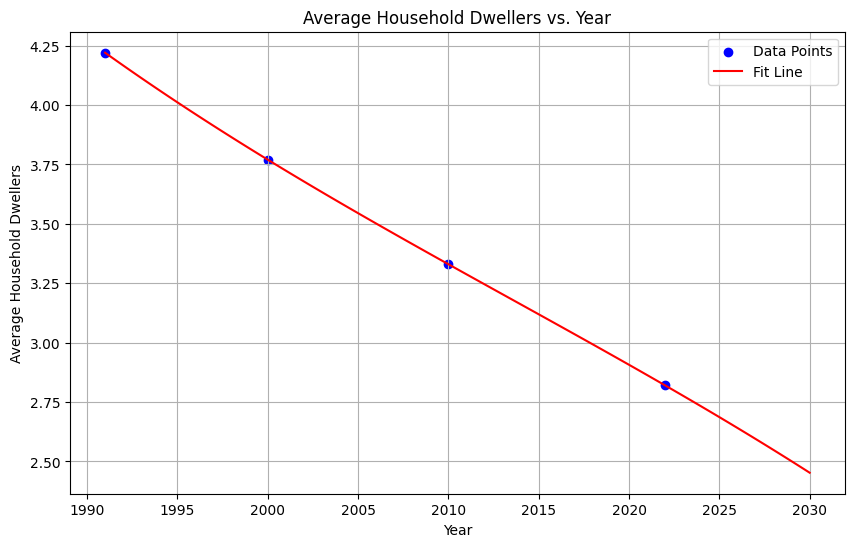

2.3537691000674386

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
years = np.array([1991, 2000, 2010, 2022])
avg_household_dwellers = np.array([4.22, 3.77, 3.33, 2.82])

# Fit a polynomial model
degree = 3
coeffs = np.polyfit(years, avg_household_dwellers, degree)

# Generate a polynomial function using the coefficients
poly_func = np.poly1d(coeffs)

# Predict the average number of household dwellers in 2032
year_2032 = 2032
avg_dwellers_2032 = poly_func(year_2032)

# Plotting
plt.figure(figsize=(10, 6))
# Scatter plot of the input data
plt.scatter(years, avg_household_dwellers, color='blue', label='Data Points')

# Fit line
x_fit_line = np.linspace(years.min(), 2030, 100)  # Extending the line to 2030
y_fit_line = poly_func(x_fit_line)
plt.plot(x_fit_line, y_fit_line, color='red', label='Fit Line')

# Styling the plot
plt.title('Average Household Dwellers vs. Year')
plt.xlabel('Year')
plt.ylabel('Average Household Dwellers')
plt.legend()
plt.grid(True)

plt.show()

avg_dwellers_2032

In [ ]:
!pip install datashader colorcet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.2 MB/s eta 0:00:00
